# 1 Introduction

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.optim
import torch.functional as F

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d

import time

%matplotlib inline

In [2]:
mb_size = 50 # mini-batch size of 100

In [3]:
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5),
                                                 (0.5, 0.5, 0.5))])

In [4]:
# split dataset in trainset and testset. The trainset consists of 60000 images, the testset of 10000 imgs.

trainset = dset.MNIST("./", download = True,
                     train = True,
                     transform = trans)

testset = dset.MNIST("./", download = True,
                     train = False,
                     transform = trans)

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                         shuffle=True, num_workers=1,
                                         pin_memory=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=mb_size,
                                         shuffle=True, num_workers=1,
                                         pin_memory=True)


In [6]:
classnames = [str(i) for i in range(10)]

def imshow(img, title="", cmap = "Greys_r"): #convert tensor to image
    plt.title(title)
    img = img / 2 + 0.5     # unnormalize
    numpyimg = img.numpy()[0]
    plt.imshow(numpyimg, cmap = cmap)
    

def display_10_images_from_dataset(dataset, class_names):
    """
    plots 10 randomly chosen images from a given dataset
    """
    display = [] #holds tuples of image and respective label
    for _ in range(10):
        index = np.random.randint(0,len(dataset)+1)
        display.append(dataset[index])
    
    nr = 1
    fig, axes = plt.subplots(2,5,sharex='col',sharey='row', figsize = (14,9))
    for image, label in display:
        axes[(nr-1)//5][(nr-1)%5] = plt.subplot(2,5,nr)
        plt.title(class_names[label], fontsize = 16)
        imshow(image, title = class_names[label])
        nr+=1
    fig.subplots_adjust(hspace=-0.4)
    plt.setp([a.get_xticklabels() for a in fig.axes[0:5]], visible=False)
    plt.setp([a.get_yticklabels() for a in fig.axes[1:5]+fig.axes[6:]], visible=False)
    plt.show()
    plt.savefig("previewMNIST.png")

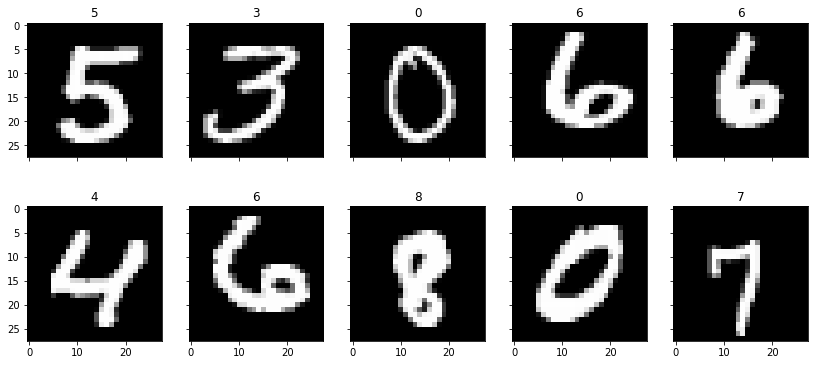

In [7]:
display_10_images_from_dataset(testset, classnames)

In [8]:
def init_weights(shape):
    # xavier initialization (a good initialization is important!)
    # http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
    fan_in = shape[0]
    fan_out = shape[1]
    variance = 2.0/(fan_in + fan_out)
    w = torch.randn(size=shape)*np.sqrt(variance)
    w.requires_grad = True
    return w

In [9]:
def rectify(X):
    return torch.max(torch.zeros_like(X), X)

In [10]:
# you can also use torch.nn.functional.softmax on future sheets
def softmax(X):
    c = torch.max(X, dim=1)[0].reshape(mb_size, 1)
    # this avoids a blow up of the exponentials
    # but calculates the same formula
    stabelized = X-c
    exp = torch.exp(stabelized)
    return exp/torch.sum(exp, dim=1).reshape(mb_size, 1)

In [11]:
# this is an example as a reduced version of the pytorch internal RMSprop optimizer
class RMSprop(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-4, alpha=0.9, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(1 - alpha, grad, grad)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(-group['lr'], grad, avg)

In [12]:
def model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    #X = dropout(X, p_drop_input)
    h = rectify(X @ w_h)
    #h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    #h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [13]:
w_h = init_weights((784, 50))
w_h2 = init_weights((50, 50))
w_o = init_weights((50, 10))

optimizer = RMSprop([w_h, w_h2, w_o])

In [14]:
dataloader = trainloader

In [15]:
# put this into a training loop over 100 epochs
for (_, (X, y)) in enumerate(dataloader, 0):
    noise_py_x = model(X.reshape(mb_size, 784), w_h, w_h2, w_o, 0.8, 0.7)
    cost = torch.nn.functional.cross_entropy(noise_py_x, y)
    cost.backward()
    print('Loss: %.4f' % cost)
    optimizer.step()

Loss: 2.4616
Loss: 2.2623
Loss: 2.2687
Loss: 2.3062
Loss: 1.9459
Loss: 1.8585
Loss: 1.7999
Loss: 1.8672
Loss: 1.5682
Loss: 1.6160
Loss: 1.5095
Loss: 1.4167
Loss: 1.3357
Loss: 1.2428
Loss: 1.2929
Loss: 1.2513
Loss: 1.0737
Loss: 1.0431
Loss: 0.9244
Loss: 0.8819
Loss: 0.8752
Loss: 0.9034
Loss: 0.9561
Loss: 0.9420
Loss: 0.6420
Loss: 0.8193
Loss: 0.9044
Loss: 0.8192
Loss: 0.6635
Loss: 0.9786
Loss: 0.8285
Loss: 0.8810
Loss: 0.7102
Loss: 0.8722
Loss: 0.7622
Loss: 0.9330
Loss: 0.8628
Loss: 0.5893
Loss: 0.8791
Loss: 0.8498
Loss: 0.6238
Loss: 0.8118
Loss: 0.6374
Loss: 0.6403
Loss: 0.5777
Loss: 0.6154
Loss: 0.8124
Loss: 0.7551
Loss: 0.4743
Loss: 0.9171
Loss: 0.6680
Loss: 0.4804
Loss: 0.4202
Loss: 0.7785
Loss: 0.7798
Loss: 0.6439
Loss: 0.7925
Loss: 0.5243
Loss: 0.8232
Loss: 1.1416
Loss: 0.9142
Loss: 0.5445
Loss: 0.5664
Loss: 0.5694
Loss: 0.7296
Loss: 0.7483
Loss: 0.6519
Loss: 0.6084
Loss: 0.5755
Loss: 0.6159
Loss: 0.7813
Loss: 0.8101
Loss: 0.8068
Loss: 1.1041
Loss: 0.6524
Loss: 0.7702
Loss: 0.5993

# 2 Dropout

In [13]:
def dropout1(X, p_drop=1.):
    if 0 < p_drop < 1:
        phi = torch.tensor(np.random.binomial(1, p_drop, X.size())).float()
        X = phi*X/p_drop
        return X.float()
    else:
        return X.float()

def dropout(X, p_drop=1.):
    if 0 < p_drop < 1:
        phi = torch.bernoulli(torch.full(X.shape, p_drop))
        X = phi*X/p_drop
        return X.float()
    else:
        return X.float()

In [14]:
def model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    h = rectify(X @ w_h)
    h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [16]:
w_h = init_weights((784, 50))
w_h2 = init_weights((50, 50))
w_o = init_weights((50, 10))

optimizer = RMSprop([w_h, w_h2, w_o])

In [39]:
# put this into a training loop over 100 epochs
for (_, (X, y)) in enumerate(dataloader, 0):
    noise_py_x = model(X.reshape(mb_size, 784), w_h, w_h2, w_o, 0.8, 0.7)
    cost = torch.nn.functional.cross_entropy(noise_py_x, y)
    cost.backward()
    print("Loss: {}".format(cost))
    optimizer.step()

Loss: 3.235685110092163
Loss: 2.6122305393218994
Loss: 2.633882761001587
Loss: 2.463536262512207
Loss: 2.253995418548584
Loss: 2.227691173553467
Loss: 2.2037668228149414
Loss: 2.2376036643981934
Loss: 2.2737526893615723
Loss: 2.1525075435638428
Loss: 2.1420462131500244
Loss: 2.104735851287842
Loss: 2.2754225730895996
Loss: 2.1633718013763428
Loss: 2.124685525894165
Loss: 2.085428237915039
Loss: 2.080772876739502
Loss: 1.9635969400405884
Loss: 1.9688693284988403
Loss: 2.071608543395996
Loss: 1.9973366260528564
Loss: 1.8948277235031128
Loss: 1.8804954290390015
Loss: 1.899318814277649
Loss: 1.8611576557159424
Loss: 1.9064974784851074
Loss: 1.904478907585144
Loss: 1.9299267530441284
Loss: 1.7353285551071167
Loss: 1.746910572052002
Loss: 1.9866044521331787
Loss: 1.872605323791504
Loss: 1.9907395839691162
Loss: 1.8297711610794067
Loss: 1.760430932044983
Loss: 1.9318454265594482
Loss: 1.8175140619277954
Loss: 1.8376332521438599
Loss: 1.6989854574203491
Loss: 1.582572340965271
Loss: 1.84457552

Loss: 1.2563494443893433
Loss: 1.403342843055725
Loss: 1.1448407173156738
Loss: 1.2700246572494507
Loss: 1.197383999824524
Loss: 1.1524964570999146
Loss: 1.1833837032318115
Loss: 1.2829405069351196
Loss: 1.2575676441192627
Loss: 1.3691112995147705
Loss: 1.1953160762786865
Loss: 0.9843840003013611
Loss: 1.049376130104065
Loss: 1.2238192558288574
Loss: 1.0818769931793213
Loss: 1.221265435218811
Loss: 1.296981692314148
Loss: 1.2105437517166138
Loss: 1.3517882823944092
Loss: 1.4353647232055664
Loss: 1.157196044921875
Loss: 1.3252780437469482
Loss: 1.3122432231903076
Loss: 1.1853066682815552
Loss: 1.2519562244415283
Loss: 1.3399854898452759
Loss: 1.3301687240600586
Loss: 1.2446739673614502
Loss: 0.9673069715499878
Loss: 1.179593563079834
Loss: 1.198248028755188
Loss: 1.2492250204086304
Loss: 1.1838258504867554
Loss: 1.1154186725616455
Loss: 1.2435503005981445
Loss: 1.1733181476593018
Loss: 1.2816259860992432
Loss: 1.4226664304733276
Loss: 1.1587389707565308
Loss: 1.1353973150253296
Loss: 1.

(b) Explanation here!
probably because random dropouts draw the NN away from overfitting/minima and allow for a well trained network to fine-adjust to a certain degree

# 3 Parametric Relu

In [21]:
def PRelu(X,a):
        return torch.where(X > 0, X, a*X)

In [15]:
def model(X, w_h, w_h2, w_o, a, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    h = PRelu(X @ w_h, a)
    h = dropout(h, p_drop_hidden)
    h2 = PRelu(h @ w_h2, a)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [16]:
w_h = init_weights((784, 50))
w_h2 = init_weights((50, 50))
w_o = init_weights((50, 10))
a = torch.tensor([-0.1], requires_grad = True)

optimizer = RMSprop([w_h, w_h2, w_o, a])

In [43]:
# put this into a training loop over 100 epochs
for (_, (X, y)) in enumerate(dataloader, 0):
    noise_py_x = model(X.reshape(mb_size, 784), w_h, w_h2, w_o, a, 0.8, 0.7)
    cost = torch.nn.functional.cross_entropy(noise_py_x, y)
    cost.backward()
    #print("Loss: {:3f}".format(cost))
    print('step: ', _)
    print('loss: %.4f' % cost)
    print('a: %.4f' % a)
    optimizer.step()

step:  0
loss: 3.4085
a: -0.1000
step:  1
loss: 2.5221
a: -0.0968
step:  2
loss: 2.5012
a: -0.0941
step:  3
loss: 2.6047
a: -0.0919
step:  4
loss: 2.3506
a: -0.0891
step:  5
loss: 2.4400
a: -0.0866
step:  6
loss: 2.3091
a: -0.0840
step:  7
loss: 2.3205
a: -0.0816
step:  8
loss: 2.3555
a: -0.0792
step:  9
loss: 2.3413
a: -0.0770
step:  10
loss: 2.3310
a: -0.0750
step:  11
loss: 2.4262
a: -0.0729
step:  12
loss: 2.2930
a: -0.0709
step:  13
loss: 2.3100
a: -0.0690
step:  14
loss: 2.2143
a: -0.0672
step:  15
loss: 2.2310
a: -0.0655
step:  16
loss: 2.2795
a: -0.0639
step:  17
loss: 2.3911
a: -0.0623
step:  18
loss: 2.2091
a: -0.0607
step:  19
loss: 2.1138
a: -0.0591
step:  20
loss: 2.1172
a: -0.0576
step:  21
loss: 2.2578
a: -0.0561
step:  22
loss: 2.2086
a: -0.0546
step:  23
loss: 2.1716
a: -0.0532
step:  24
loss: 2.0940
a: -0.0518
step:  25
loss: 2.1407
a: -0.0503
step:  26
loss: 2.1106
a: -0.0489
step:  27
loss: 2.0607
a: -0.0474
step:  28
loss: 2.1161
a: -0.0460
step:  29
loss: 1.9676
a

step:  245
loss: 1.5209
a: -0.0017
step:  246
loss: 1.5846
a: -0.0019
step:  247
loss: 1.3325
a: -0.0028
step:  248
loss: 1.3627
a: -0.0039
step:  249
loss: 1.6347
a: -0.0049
step:  250
loss: 1.4698
a: -0.0052
step:  251
loss: 1.5196
a: -0.0057
step:  252
loss: 1.4727
a: -0.0055
step:  253
loss: 1.4236
a: -0.0046
step:  254
loss: 1.3833
a: -0.0031
step:  255
loss: 1.2631
a: -0.0018
step:  256
loss: 1.5503
a: -0.0013
step:  257
loss: 1.7177
a: -0.0021
step:  258
loss: 1.5474
a: -0.0038
step:  259
loss: 1.6490
a: -0.0051
step:  260
loss: 1.3808
a: -0.0059
step:  261
loss: 1.5072
a: -0.0061
step:  262
loss: 1.4202
a: -0.0058
step:  263
loss: 1.4471
a: -0.0049
step:  264
loss: 1.4630
a: -0.0037
step:  265
loss: 1.2740
a: -0.0028
step:  266
loss: 1.6468
a: -0.0021
step:  267
loss: 1.3712
a: -0.0020
step:  268
loss: 1.4291
a: -0.0029
step:  269
loss: 1.7333
a: -0.0041
step:  270
loss: 1.5332
a: -0.0057
step:  271
loss: 1.3080
a: -0.0071
step:  272
loss: 1.6563
a: -0.0082
step:  273
loss: 1.3

step:  484
loss: 1.8223
a: -0.0142
step:  485
loss: 1.6479
a: -0.0133
step:  486
loss: 1.8781
a: -0.0122
step:  487
loss: 1.7053
a: -0.0110
step:  488
loss: 1.6862
a: -0.0098
step:  489
loss: 1.5665
a: -0.0085
step:  490
loss: 1.5441
a: -0.0072
step:  491
loss: 1.5239
a: -0.0060
step:  492
loss: 1.6709
a: -0.0048
step:  493
loss: 1.4837
a: -0.0037
step:  494
loss: 1.5473
a: -0.0026
step:  495
loss: 1.5519
a: -0.0015
step:  496
loss: 1.8529
a: -0.0005
step:  497
loss: 1.7404
a: 0.0002
step:  498
loss: 1.6038
a: -0.0001
step:  499
loss: 1.6841
a: -0.0006
step:  500
loss: 1.5672
a: -0.0014
step:  501
loss: 1.6632
a: -0.0022
step:  502
loss: 1.6321
a: -0.0032
step:  503
loss: 1.4383
a: -0.0041
step:  504
loss: 1.6570
a: -0.0051
step:  505
loss: 1.4947
a: -0.0061
step:  506
loss: 1.6434
a: -0.0070
step:  507
loss: 1.5852
a: -0.0079
step:  508
loss: 1.6863
a: -0.0088
step:  509
loss: 1.5260
a: -0.0097
step:  510
loss: 1.6556
a: -0.0104
step:  511
loss: 1.5281
a: -0.0112
step:  512
loss: 1.57

As one can see, the PRelu is adaptedin each step.

# 4. Convolutional layers

We use the following code snippets to build the convolutional network:

```python
    from torch . nn . functional import conv2d , max_pool2d
    convolutional_layer = rectify ( conv2d ( previous_layer , weightvector ))
    subsampleing_layer = max_pool_2d ( convolutional_layer , (2 , 2) ) # reduces window 2x2 to 1 pixel
    out_layer = dropout ( subsample_layer , p_drop_input )
```

In [55]:
from torch.nn.functional import conv2d, max_pool2d

lr = 2e-5

# given on exercise sheet
f1, f2, f3 = 32, 64, 128
pic_in1, pic_in2, pic_in3 = 1, 32, 64 
k_x1, k_x2, k_x3 = 5, 5, 2
k_y1, k_y2, k_y3 = 5, 5, 2

# modify for more speed
f1, f2, f3 = 20, 40, 80
pic_in1, pic_in2, pic_in3 = 1, 20, 40
k_x1, k_x2, k_x3 = 5, 5, 2
k_y1, k_y2, k_y3 = 5, 5, 2


activation = 'prelu'


w_conv1 = init_weights((f1, pic_in1, k_x1, k_y1))
w_conv2 = init_weights((f2, pic_in2, k_x2, k_y2))
w_conv3 = init_weights((f3, pic_in3, k_x3, k_y3))

def conv_layer(X, weightvector, p_drop):
    X = rectify(conv2d (X, weightvector))
    X = max_pool2d(X, (2 , 2)) # reduces window 2x2 to 1 pixel
    return dropout(X, p_drop)

def get_num_output_pix(w_conv1, w_conv2, w_conv3, p_drop_input):
    def cnn_pre(X, w_conv1, w_conv2, w_conv3, p_drop_input):
        X = conv_layer(X, w_conv1, p_drop_input)
        X = conv_layer(X, w_conv2, p_drop_input)
        X = conv_layer(X, w_conv3, p_drop_input)
        return X
    Y = torch.randn((mb_size, 1, 28, 28)) # standard mnist tensor size
    # get output size
    Y = cnn_pre(Y, w_conv1, w_conv2, w_conv3, p_drop_input)
    return Y.size()[1]

number_of_output_pixels = get_num_output_pix(w_conv1, w_conv2, w_conv3, 0.5)
print('number of output pixels = ', number_of_output_pixels)

# given on exercise sheet
w_h2 = init_weights((number_of_output_pixels, 625))
w_o = init_weights((625, 10))

# modify for more speed
w_h2 = init_weights((number_of_output_pixels, 250))
w_o = init_weights((250, 10))

# in case pReLU is needed:
if activation == 'prelu':
    a = torch.tensor([-0.1], requires_grad = True)
elif activation == 'relu':
    a = torch.tensor([0.], requires_grad = False)
else:
    print('Please enter valid activation function (either relu or prelu)')

if activation == 'prelu':
    optimizer = RMSprop([w_conv1, w_conv2, w_conv3, w_h2, w_o, a], lr = lr)
elif activation == 'relu':
    optimizer = RMSprop([w_conv1, w_conv2, w_conv3, w_h2, w_o], lr = lr)
else:
    print('Please enter valid activation function (either relu or prelu)')    

# add a here if running with pReLU
def cnn(X, w_conv1, w_conv2, w_conv3, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = conv_layer(X, w_conv1, p_drop_input)
    X = conv_layer(X, w_conv2, p_drop_input)
    X = conv_layer(X, w_conv3, p_drop_input)
    X = X.reshape(mb_size, number_of_output_pixels)
    h2 = PRelu(X @ w_h2, a)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

number of output pixels =  80


In [78]:
# define train loop
def train(train_loader, epoch, log_interval):
    # print to screen every log_interval
    for batch_idx, (data, target) in enumerate(train_loader):
        pre_softmax = cnn(data.reshape(-1, 1, 28, 28), w_conv1, w_conv2, w_conv3, w_h2, w_o, 0.8, 0.7)
        #output = softmax(pre_softmax)
        # note: torch.nn.functional.cross_entropy applies log_softmax
        loss = torch.nn.functional.cross_entropy(pre_softmax, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            #print('pre_soft size: ', pre_softmax.size())
            #print('target size: ', target.size())
            #print('loss size: ', loss.size())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))

# define test loop
def test(test_loader):
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = cnn(data.reshape(-1, 1, 28, 28), w_conv1, w_conv2, w_conv3, w_h2, w_o, 1., 1.)
        loss = torch.nn.functional.cross_entropy(output, target) # returns average over minibatch
        test_loss += loss # maybe loss.data[0] ?  # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max probability
        correct += pred.eq(target.data.view_as(pred)).sum() # sum up pair-wise equalities (marked with 1, others 0)

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [79]:
def run_model(train_loader, test_loader, num_epochs, log_interval):
    # run training
    t1 = time.time()
    for epoch in range(1, num_epochs + 1):
        train(train_loader, epoch, log_interval)
        test(test_loader)       
    t2 = time.time()
    print('Training took {:.1f} seconds (or {:.1f} minutes)'.format(t2 - t1, (t2 - t1) / 60))

In [59]:
N_epochs = 10
log_interval = 200

run_model(trainloader, testloader, N_epochs, log_interval)

Train Epoch: 1 [0/60000 (0%)]	Loss: 30.0028
Train Epoch: 1 [10000/60000 (17%)]	Loss: 9.7253
Train Epoch: 1 [20000/60000 (33%)]	Loss: 6.6157
Train Epoch: 1 [30000/60000 (50%)]	Loss: 3.2101
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.7628
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.2692

Test set: Average loss: 0.0451, Accuracy: 1456/10000 (14%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.6366
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.2841
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.2028
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.3096
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.2625
Train Epoch: 2 [50000/60000 (83%)]	Loss: 2.3449

Test set: Average loss: 0.0458, Accuracy: 1068/10000 (10%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.2836
Train Epoch: 3 [10000/60000 (17%)]	Loss: 2.2142
Train Epoch: 3 [20000/60000 (33%)]	Loss: 2.3127
Train Epoch: 3 [30000/60000 (50%)]	Loss: 2.2287
Train Epoch: 3 [40000/60000 (67%)]	Loss: 2.2821
Train Epoch: 3 [50000/60000 (83%)]	Loss: 2.2145

Test set: Average loss: 0.0

In [60]:
print(a)

tensor(1.00000e-03 *
       [ 6.1090])


By printing a to the screen we see that it is indeed modified during training (initial value: a = -0.01)

## issues:
 - find nice hyperparameters (learning rate, dropout, ...)

# 4.2 Application of Convolutional Network

First, we sketch the network architecure in order to determine the number of neurons in the last layer. For this purpose we have to take into account the following:<br>
<ul>
<li>Convolving an (n x n) image with a (5 x 5) filter without padding produces an output of dimension (n-4 x n-4) since we lose 2 pixels on each side of the image.</li>
<li>Applying a (2 x 2) max pooling layer on  a (n x n) image gives an (n/2 x n/2) output.</li>
<li>Convolving an (n x n) image with a (2 x 2) filter witout padding produces an output of dimension (n-1 x n-1).</li>
<li>In the last step, we apply a (2 x 2) pooling operation on a (3 x 3) image where the dimensions of filter and image do not really match. Nevertheless we obtain a (1 x 1) output, but maybe, it would be more convenient to apply a (3 x 3) filter in the previous layer such that we could apply the (2 x 2) pooling to a (2 x 2) image?</li>
</ul>
Taking all this into account, we obtain the architecture displayed below and can read off that the last convolutional layer contains (128 x 1 x 1) = 128 pixels.

In [26]:
architecture = plt.imread('architecture.png')
fig, ax = plt.subplots(figsize=(40,12))
ax.imshow(architecture)
plt.axis('off')

FileNotFoundError: [Errno 2] No such file or directory: 'architecture.png'

Now, we visualize one image of the test set, its convolution with 3 filters of the first convolutional layer and the corresponding filter weights.

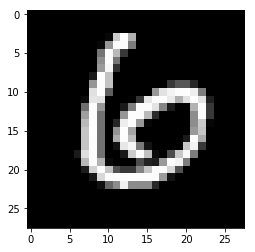

In [61]:
index = 11
selected_image = testset[index]
plt.imshow(selected_image[0][0], cmap='gray')

In [62]:
filters_of_interest = torch.tensor([1,2,3])
print(selected_image[0].size())
feature_maps = conv2d(selected_image[0].unsqueeze(0), w_conv1[filters_of_interest,:,:,:])
print(feature_maps.size())
feature_maps = feature_maps.detach()  # detach from comp. graph
filters = w_conv1.detach()
print(filters.size())

torch.Size([1, 28, 28])
torch.Size([1, 3, 24, 24])
torch.Size([20, 1, 5, 5])


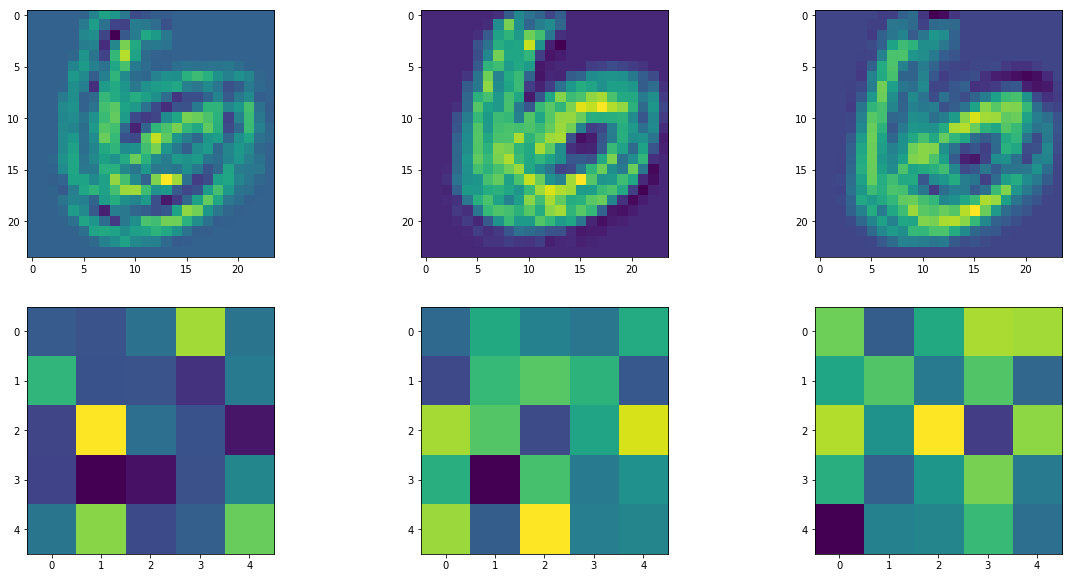

In [63]:
fig1, ax1 = plt.subplots(2,3, figsize=(20,10))
for i in range(3):
    ax1[0,i].imshow(feature_maps[0,i,:,:])
    ax1[1,i].imshow(filters[filters_of_interest[i]][0])

In the upper row we show the feature maps which have been obtained by convolving the input image with the three filters shown in the lower row.

## For comparison: feature maps and filters with no training

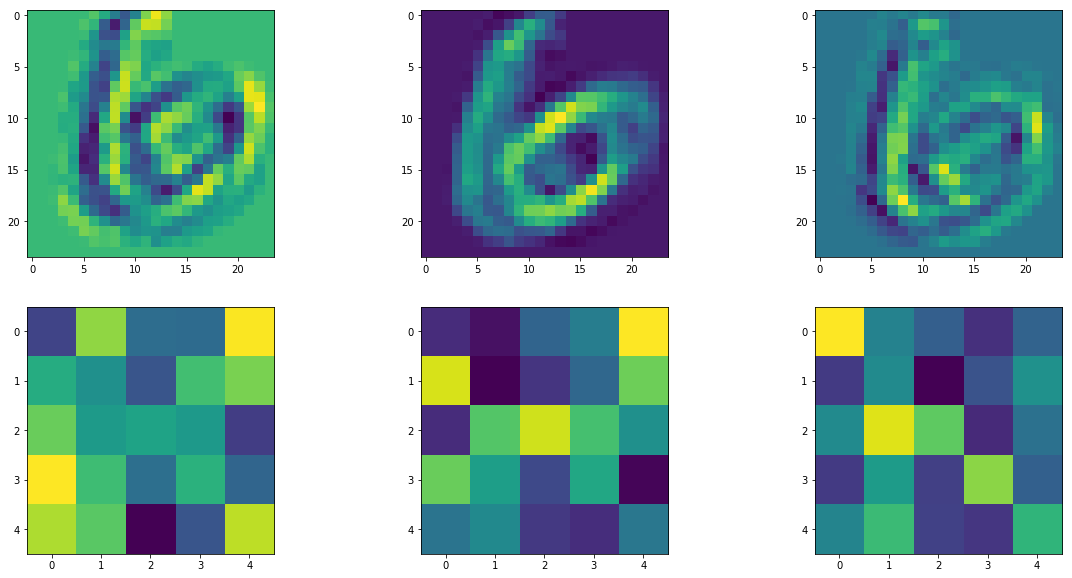

In [64]:
w_conv1 = init_weights((f1, pic_in1, k_x1, k_y1))
filters_of_interest = torch.tensor([1,2,3])
feature_maps = conv2d(selected_image[0].unsqueeze(0), w_conv1[filters_of_interest,:,:,:])
feature_maps = feature_maps.detach()  # detach from comp. graph
filters = w_conv1.detach()

fig1, ax1 = plt.subplots(2,3, figsize=(20,10))
for i in range(3):
    ax1[0,i].imshow(feature_maps[0,i,:,:])
    ax1[1,i].imshow(filters[filters_of_interest[i]][0])

# Try different network architecture

### 1. add additional convolutional layer

#### parameter initialization

In [76]:
lr = 2e-5

# given on exercise sheet
f1, f2, f3 = 32, 64, 128
pic_in1, pic_in2, pic_in3 = 1, 32, 64 
k_x1, k_x2, k_x3 = 5, 5, 2
k_y1, k_y2, k_y3 = 5, 5, 2

# modify for more speed
f1, f2, f3, f4 = 32, 32, 32, 64
pic_in1, pic_in2, pic_in3, pic_in4 = 1, 32, 32, 32
k_x1, k_x2, k_x3, k_x4 = 3, 3, 2, 2
k_y1, k_y2, k_y3, k_y4 = 3, 3, 2, 2


activation = 'prelu'


w_conv1 = init_weights((f1, pic_in1, k_x1, k_y1))
w_conv2 = init_weights((f2, pic_in2, k_x2, k_y2))
w_conv3 = init_weights((f3, pic_in3, k_x3, k_y3))
w_conv4 = init_weights((f4, pic_in4, k_x4, k_y4))

def get_num_output_pix(w_conv1, w_conv2, w_conv3, w_conv4, p_drop_input):
    def cnn_pre(X, w_conv1, w_conv2, w_conv3, w_conv4, p_drop_input):
        X = conv_layer(X, w_conv1, p_drop_input)
        X = conv_layer(X, w_conv2, p_drop_input)
        X = conv_layer(X, w_conv3, p_drop_input)
        # do not apply max_pooling after last layer (input dimension too low)
        X = rectify(conv2d (X, w_conv4))
        X = dropout(X, p_drop_input)
        return X
    Y = torch.randn((mb_size, 1, 28, 28)) # standard mnist tensor size
    # get output size
    Y = cnn_pre(Y, w_conv1, w_conv2, w_conv3, w_conv4, p_drop_input)
    return Y.size()[1]
number_of_output_pixels = get_num_output_pix(w_conv1, w_conv2, w_conv3, w_conv4, 0.5)
print('number of output pixels = ', number_of_output_pixels)

# given on exercise sheet
w_h2 = init_weights((number_of_output_pixels, 625))
w_o = init_weights((625, 10))

# modify for more speed
w_h2 = init_weights((number_of_output_pixels, 250))
w_o = init_weights((250, 10))

# in case pReLU is needed:
if activation == 'prelu':
    a = torch.tensor([-0.1], requires_grad = True)
elif activation == 'relu':
    a = torch.tensor([0.], requires_grad = False)
else:
    print('Please enter valid activation function (either relu or prelu)')

if activation == 'prelu':
    optimizer = RMSprop([w_conv1, w_conv2, w_conv3, w_conv4, w_h2, w_o, a], lr = lr)
elif activation == 'relu':
    optimizer = RMSprop([w_conv1, w_conv2, w_conv3, w_conv4, w_h2, w_o], lr = lr)
else:
    print('Please enter valid activation function (either relu or prelu)')    

# add a here if running with pReLU
def cnn(X, w_conv1, w_conv2, w_conv3, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = conv_layer(X, w_conv1, p_drop_input)
    X = conv_layer(X, w_conv2, p_drop_input)
    X = conv_layer(X, w_conv3, p_drop_input)
    X = rectify(conv2d (X, w_conv4))
    X = dropout(X, p_drop_input)
    X = X.reshape(mb_size, number_of_output_pixels)
    h2 = PRelu(X @ w_h2, a)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

number of output pixels =  64


#### running the model

In [ ]:
N_epochs = 10
log_interval = 200

run_model(trainloader, testloader, N_epochs, log_interval)

Train Epoch: 1 [0/60000 (0%)]	Loss: 3.9090
Train Epoch: 1 [10000/60000 (17%)]	Loss: 3.0006
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.4719
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.3394
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.3524
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.2874

Test set: Average loss: 0.0461, Accuracy: 944/10000 (9%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.3524
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.3074
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.3076
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.2982
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.2837
Train Epoch: 2 [50000/60000 (83%)]	Loss: 2.3021

Test set: Average loss: 0.0461, Accuracy: 980/10000 (9%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.3055
Train Epoch: 3 [10000/60000 (17%)]	Loss: 2.3026
Train Epoch: 3 [20000/60000 (33%)]	Loss: 2.3026
Train Epoch: 3 [30000/60000 (50%)]	Loss: 2.3026
Train Epoch: 3 [40000/60000 (67%)]	Loss: 2.3026
Train Epoch: 3 [50000/60000 (83%)]	Loss: 2.3026

Test set: Average loss: 0.0461, 

-> We do not any observe significant imporovement

### 2. Anistotropic filters
Then we try to use anisotropic filters with $k_x \neq k_y$.